<a href="https://colab.research.google.com/github/chetan-parthiban/MSSP608/blob/master/Lectures/Day2_TestSets_Metrics_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
import calendar

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold

# Prerequisites (What you should know from Day 1)

Here's what you should understand well from day 1 to be able to understand this notebook. If you don't feel comfortable with any of these topics its HIGHLY recommended that you review it before continuing with this notebook!

- Preprocessing the data with pandas
- What are decision trees
- How to train a decision tree in scikit-learn

# Downloading and Preprocessing the Data (Same as in Day 1)

If you understand this part of the Day 1 notebook, then feel free to skip over reading this part of the notebook since it is exactly the same. 

In [0]:
# Download the data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ' -O bikeshare_train.csv

--2020-01-17 18:30:07--  https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ
Resolving docs.google.com (docs.google.com)... 172.217.203.113, 172.217.203.139, 172.217.203.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/plidd4ugea02ilnn8olmcmsa4pknu9cg/1579284000000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download [following]
--2020-01-17 18:30:08--  https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/plidd4ugea02ilnn8olmcmsa4pknu9cg/1579284000000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download
Resolving doc-0s-5c-docs.googleusercontent.com (doc-0s-5c-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting

In [0]:
# Load the data with pandas and properly setup the date/time data
bikeshare = pd.read_csv("bikeshare_train.csv")
bikeshare["date_objs"] = bikeshare["datetime"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [0]:
# Create columns for different parts of the date/time data
bikeshare["hour"] = bikeshare["date_objs"].apply(lambda x: x.hour)
bikeshare["day"] = bikeshare["date_objs"].apply(lambda x: x.day)
bikeshare["month"] = bikeshare["date_objs"].apply(lambda x: x.month)
bikeshare["year"] = bikeshare["date_objs"].apply(lambda x: x.year)
bikeshare["weekday"] = bikeshare["date_objs"].apply(lambda x: x.weekday())
bikeshare["plot_time"] = bikeshare["datetime"].apply(dates.datestr2num)

bikeshare["month_str"] = bikeshare["month"].apply(lambda x: calendar.month_name[x])
bikeshare["weekday_str"] = bikeshare["weekday"].apply(lambda x: calendar.day_name[x])

# Create column to tell to represent the traffic ammount 
bikeshare["high_traffic"] = bikeshare["count"] > 145

# Create columns for the weather data
def weather_norm(x):
    if x == 1:
        return "clear"
    if x == 2:
        return "overcast"
    if x > 2:
        return "gross"
    
bikeshare["weather_norm"] = bikeshare["weather"].apply(weather_norm)

# Check the distribution of the weather data and preview the dataframe
print(bikeshare["weather_norm"].value_counts())
bikeshare.head()

clear       7192
overcast    2834
gross        860
Name: weather_norm, dtype: int64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date_objs,hour,day,month,year,weekday,plot_time,month_str,weekday_str,high_traffic,weather_norm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,0,1,1,2011,5,734138.000000,January,Saturday,False,clear
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,1,1,1,2011,5,734138.041667,January,Saturday,False,clear
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2,1,1,2011,5,734138.083333,January,Saturday,False,clear
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,3,1,1,2011,5,734138.125000,January,Saturday,False,clear
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,4,1,1,2011,5,734138.166667,January,Saturday,False,clear


# Train/Test Splits

Setting data into different groups for training and testing is a very important part of the data sciene workflow. Many of the models we use can easily fit the data set they are trained on perfectly, but this usually results in nonsensical models that are "overfitted" to the data and cannot generalize to any other new  data points. This makes them basically useless. Setting aside some data for testing allows us to simulate this change and perform better evaluations of our model. [Check this resource out for more info on train/test splits.](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)


## Creating the Train/Test Split

Now that we know that using a train/test split is important for properly evaluating our models, let's consider some different ways to potentially create that train/test split. We'll see that we have to be careful when creating our train/test split to make sure that it makes sense. 

### The most naive split

What is the simplest way to create a train/test split? Draw a line at some point in the dataset and take one side to be the train data and the other to be the test data! The following steps detail an easy procedure to do this. 
1.   Pick a size for the test set (in this case, we will use 20% of the data for the test set)
2.   Take the first section of data as the train set
3.   Take the second section of data as the test set



In [0]:
# Calculate where the cutoff should be if we want 20% of our data to be in the test set
test_set_percentage = 0.2
test_set_size = int(len(bikeshare)*test_set_percentage) 
test_cutoff = len(bikeshare) - test_set_size 

# Take everything before the cutoff to be the train set
bikeshare_train = bikeshare[:test_cutoff]

# Take everything after the cutoff to be the test set 
bikeshare_test = bikeshare[test_cutoff:]

# Lets check to make sure the size of our train and test data seem about correct
print("Size of train data:", len(bikeshare_train))
print("Size of test  data:", len(bikeshare_test))

Size of train data: 8709
Size of test  data: 2177


But doing this split naively can sometimes be a big problem! To see why, lets look at the distribution of the months represented in the train set and the months represented in the test set.

In [0]:
print("Training set months:")
print(bikeshare_train["month_str"].value_counts())
print('-----------')
print("Test set months:")
print(bikeshare_test["month_str"].value_counts())

Training set months:
July         912
May          912
June         912
April        909
March        901
February     901
January      884
August       558
November     456
December     456
October      455
September    453
Name: month_str, dtype: int64
-----------
Test set months:
September    456
December     456
October      456
November     455
August       354
Name: month_str, dtype: int64


### Improving our sampling method
Notice that our test set only contains 5/12 of the months! This means that whenever we run our model, we are only evaluating our model on its performance during these months. What we really want is to evaluate our model on a little bit of data from every month so, clearly, this method is not what we want for this task. 

So, how can we fix this? Lets think about why the problem is occuring in the first place. The best way to do this is to look at the data!

In [0]:
bikeshare.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date_objs,hour,day,month,year,weekday,plot_time,month_str,weekday_str,high_traffic,weather_norm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,0,1,1,2011,5,734138.000000,January,Saturday,False,clear
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,1,1,1,2011,5,734138.041667,January,Saturday,False,clear
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2,1,1,2011,5,734138.083333,January,Saturday,False,clear
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,3,1,1,2011,5,734138.125000,January,Saturday,False,clear
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,4,1,1,2011,5,734138.166667,January,Saturday,False,clear


If we look at the data, we can quickly realize that the data points are sorted by their date/time! This means that when we are taking the last 20% of the data, we are actually taking the data from the last 20% of dates/times and this is why we only see a few of the months appear in our current test set!

Lets come up with a different way to sample our test data that avoids this problem. An easy way to do this if we want 20% of our data in the test set is to through the data in order and for every 5 data points, we set the first 1 to be test data and the last 4 to be train data. Visually, we can compare the two sampling methods in the following way:

Simplest method: OOOOOOOOOOOOXXX

Improved method: OOOOXOOOOXOOOOX

Now lets try implementing this in code

In [0]:
# Calculate how often to send data to the test set (in our case for an 80/20 train/test split)
test_size = 0.2
test_modulus = int(1/test_size)

# Set 4/5 data points from each set of 5 data points to be in the train set
bikeshare_train = bikeshare.iloc[bikeshare.index % test_modulus != 0]
# Set the remaining 1 data point from each set of 5 data points to be in the test set
bikeshare_test = bikeshare.iloc[bikeshare.index % test_modulus == 0]

# Lets confirm the size of the train and test set are still about right
print("Size of train data:", len(bikeshare_train))
print("Size of test  data:", len(bikeshare_test))

# Lets examine the distribution of the months in the two datasets
print("Training set months:")
print(bikeshare_train["month_str"].value_counts())
print("Test set months:")
print(bikeshare_test["month_str"].value_counts())

Size of train data: 8708
Size of test  data: 2178
Training set months:
May          730
August       730
July         729
June         729
December     729
October      729
September    728
November     728
April        727
March        721
February     721
January      707
Name: month_str, dtype: int64
Test set months:
December     183
July         183
November     183
June         183
August       182
May          182
April        182
October      182
September    181
February     180
March        180
January      177
Name: month_str, dtype: int64


Notice how now our train and test datasets now have the same distribution of months! If we didn't look at the data, it would seem like these two methods are essentially identical and interchangable. This example shows us that sometimes a very simple modification can make a big difference and why its important to be careful when making our train/test split. 

Now, it might seem like we can always use this second method we have developed and like it will always be better than the first method. In practice, this turns out to be very false. For example, if we had taken 1 out of every 12 data points to be in our test set, our test set would be entirely data points from noon and midnight, with no other times represented! It is important to think about your data carefully before making a decision on how to do your train/test split! Here are some resources to learn more about this problem:

- [The story of a bad train/test split](https://anotherdatum.com/train-test.html)
- [Random Test/Train Splits is Not Always Enough](http://www.win-vector.com/blog/2015/01/random-testtrain-split-is-not-always-enough/)

## Comparing models with Train/Test Splits

Lets see how we can use the train/test split we created to better understand and compare different models. 

In [0]:
# Create lists of possible features (Same as in Day 1)
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_sets = {
    "date": date_features,
    "time": time_features,
    "date + time": date_features + time_features,
    "weather": weather_features,
    "all": date_features + time_features + weather_features
}

In [0]:
# We'll keep track of which classifier was the best
best = 0
best_name = None
best_actual = None
best_predictions = None

test_accuracies = []
train_accuracies = []

# For each feature set, we evaluate our model on both the train and the test set
for set_name, feature_set in feature_sets.items():

    # Create a dummyset with only the features in our feature set
    X = bikeshare.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = bikeshare["high_traffic"]

    # Use scikit-learn to create our train/test split and train our decision tree
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)
    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)

    # Calculate our accuracy on the train and test sets
    train_pred = model.predict(X_train)
    train_accuracy = 100*accuracy_score(y_train, train_pred)
    test_pred = model.predict(X_test)
    test_accuracy = 100*accuracy_score(y_test, test_pred)

    # Keep track of the best model on the test set
    if test_accuracy > best:
        best = test_accuracy
        best_name = set_name
        best_actual = y_test
        best_predictions = test_pred
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    # Display the accuracy on the train and test set for each model
    print(f"Results for {set_name}:")
    print(f"Accuracy on the train set: {train_accuracy:.1f}")
    print(f"Accuracy on the test set: {test_accuracy:.1f}")
    print("------------------------")
    
print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")    

Results for date:
Accuracy on the train set: 66.4
Accuracy on the test set: 62.6
------------------------
Results for time:
Accuracy on the train set: 81.0
Accuracy on the test set: 80.1
------------------------
Results for date + time:
Accuracy on the train set: 100.0
Accuracy on the test set: 90.8
------------------------
Results for weather:
Accuracy on the train set: 90.7
Accuracy on the test set: 68.5
------------------------
Results for all:
Accuracy on the train set: 100.0
Accuracy on the test set: 90.7
------------------------
Best feature set is: date + time 
With: 90.8% accuracy.


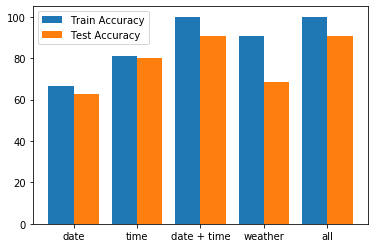

In [0]:
locs = np.arange(len(test_accuracies))

ax = plt.gca()
ax.bar(locs-0.2, train_accuracies, width=0.4)
ax.bar(locs+0.2, test_accuracies, width=0.4)
ax.set_xticks(locs)
ax.set_xticklabels(list(feature_sets.keys()))
ax.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

If we had just looked at the train set, we would have thought that using date and time alone we could perfectly model the levels of bikeshare traffic. Once we look at the test accuracy, we realize that that is not true at all! While 90% accuracy is pretty great, that 10% of misclassified data demonstrates that our model is definitely not perfect. 

We can also see that the model trained on just date/time is actually better than the model trained on date/time/weather! This is an example of more data not always being better and an example of how our decision tree algorithm does not always converge to the optimal tree, just a pretty good one!

Here are some more resources diving further into comparing models using train/test splits and the convergence of decision trees:

- [Train/Test Splits and Cross Validation in Python](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
- [Disadvantages of Decision Trees (this article is pretty technical)](https://www.edupristine.com/blog/decision-trees-development-and-scoring)

# Metrics of Model Quality

While accuracy is great some of the time, there are many cases where it is not a good metric for understanding the performance of our models. Lets explore some alternate methods for evaluating our models and figure out when we should be using them. 

In [0]:
# Lets keep the predictions from the best tree that we found to use in this section
predictions = best_predictions
actual = np.array(list(best_actual))

### Accuracy

$$ accuracy = \frac{correct \space predictions}{total \space predictions} \times 100 $$

In [0]:
# Calculating accuracy manually
matches = (predictions == actual).sum() 
accuracy = matches / len(actual)
print(f"Manual accuracy metric: {100*accuracy:.1f}")

Manual accuracy metric: 90.8


In [0]:
# Calculating accuracy with scikit-learn
accuracy = accuracy_score(actual, predictions)
print(f"scikit-learn accuracy metric: {100*accuracy:.1f}")

scikit-learn accuracy metric: 90.8


#### Pros/Cons the accuracy metric

**Benefit**
- Accuracy is very intuitive and easy to understand

**Weakness**
- Accuracy can sometimes paint an inaccurate picture of the model. For example, consider a model that predicts whether or not there will be an earthquake in LA today. You could get >99% accuracy by just guessing no every time, so accuracy can be very misleading in this case!

### Confusion Matrix

The confusion matrix is a great way to visualize where our model is making errors. Elements on the diagonal represent correct predictions. Elements off the diagonal represent that the model predicted the wrong class.

![Example Confusion Matrix](https://www.mathworks.com/help/examples/nnet/win64/CreateConfusionMatrixChartExample_02.png)
  

In [0]:
# Generating our confusion matrix manually

# Helper function to display our confusion matrix nicely
def matrix_print(matrix):
    print("           Predictions")
    print(f"Actual    |", end='')
    for pred in list(matrix.keys()):
        print(f"{str(pred).rjust(10)}|", end='')
    print()
    for act in list(matrix.keys()):
        print(f"{str(act).rjust(10)}|", end='')
        for pred in list(matrix.keys()):
            cell = matrix[pred][act]
            print(f"{str(cell).rjust(10)}|", end='')
        print()

# Actually computing our confusion matrix         
def build_confusion_matrix(actual, predictions):
    confusion_matrix = {}
    for pred_value in np.unique(predictions):
        confusion_matrix[pred_value] = {}
        for act_value in np.unique(actual):
            cell_count = 0
            for i in range(len(actual)):
                if predictions[i] == pred_value and actual[i] == act_value:
                    cell_count += 1
            confusion_matrix[pred_value][act_value] = cell_count
    return confusion_matrix

conf_matrix = build_confusion_matrix(actual, predictions)
matrix_print(conf_matrix)

           Predictions
Actual    |     False|      True|
     False|       976|        97|
      True|       103|      1002|


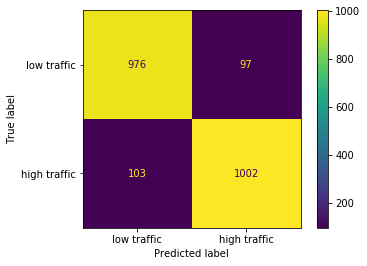

In [0]:
# Generating our confusion matrix with scikit-learn
conf_matrix = confusion_matrix(actual, predictions)
ConfusionMatrixDisplay(conf_matrix, ["low traffic", "high traffic"]).plot(values_format='.4g')
plt.show()

#### Pros/Cons of the confusion matrix

**Benefit**
- Gives us a deeper understanding of our model performance than accuracy alone

**Weakness**
- We don't get a single number out so it is hard to tell which model is "better" when comparing two models

### Cohen's Kappa

$$ \kappa = \frac{accuracy - chance \space agreement}{1 - chance \space agreement}$$


In [0]:
# Calculating Kappa Manually
matching_by_chance = 0
for label in np.unique(actual):
    predicted_probability = (predictions == label).sum() / len(predictions)
    actual_probability = (actual == label).sum() / len(actual)
    matching_by_chance += (predicted_probability * actual_probability)

print(f"Probability of matching by chance: {matching_by_chance:.3f}")
kappa = (accuracy - matching_by_chance) / (1 - matching_by_chance)
print(f"Manual kappa metric: {kappa:.3f}")

Probability of matching by chance: 0.500
Manual kappa metric: 0.816


In [0]:
# Calculating Kappa with scikit-learn
kappa = cohen_kappa_score(actual, predictions)
print(f"scikit-learn kappa metric: {kappa:.3f}")

scikit-learn kappa metric: 0.816


#### Pros/Cons of Cohen's Kappa

**Benefit**
- Gives us a single number that evaluates the accuracy of our model and compares it to a simple baseline model -- guessing randomly based on the distribution of the data

**Weakness**
- What threshold denotes a "good" kappa value is highly subjective

### Precision, Recall, and F-Score

$$ Precision = \frac{sucessful \space predictions}{predicted \space positives}$$
$$ Recall = \frac{sucessful \space predictions}{actual \space positives}$$
$$ F \mbox{-} score = \frac{2 \times precision \times recall}{precision + recall}$$

In [0]:
# Compute Precision, Recall, and F-Score Manually
# Compute number of predictions, number of correct predictions, and number of total positives
predicted_positives = (predictions == True).sum()
actual_positives = (actual == True).sum()
successful_predictions = 0
for i in range(len(predictions)):
    if predictions[i] == True and actual[i] == True:
        successful_predictions += 1

# Compute Precision Manually
precision = successful_predictions / predicted_positives
print(f"Precision: {precision:.3f}")

# Compute Recall Manually
recall = successful_predictions / actual_positives
print(f"Recall: {recall:.3f}")

#Compute F-Score Manually
f = (2*precision*recall)/(precision + recall)
print(f"F-Score: {f:.3f}")

Precision: 0.912
Recall: 0.907
F-Score: 0.909


In [0]:
# Compute Precision, Recall, and F-Score with a Confusion Matrix
conf_matrix = build_confusion_matrix(actual, predictions)

successful_positives = conf_matrix[True][True]
predicted_positives = 0
for a in conf_matrix[True].keys():
    predicted_positives += conf_matrix[True][a]

precision = successful_positives / predicted_positives
print(f"Precision: {precision:.3f}")

actual_positives = 0
for p in conf_matrix.keys():
    actual_positives += conf_matrix[p][True]
    
recall = successful_positives / actual_positives
print(f"Recall: {recall:.3f}")

f = (2*precision*recall)/(precision + recall)

print(f"F-Score: {f:.3f}")

Precision: 0.912
Recall: 0.907
F-Score: 0.909


In [0]:
# Compute Precision, Recall, and F-Score with scikit-learn
precision = precision_score(actual, predictions)
recall = recall_score(actual, predictions)
f = f1_score(actual, predictions)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F-Score: {f:.3f}")


Precision: 0.912
Recall: 0.907
F-Score: 0.909


#### Pros/Cons of F-score

**Benefit**
- Achieves a balance between precision and recall without sacrificing much of either

**Weakness**
- It is hard to interpret, and is not as useful when we care about one of the two components more than the other

**High precision is important when...**
- You are working with limited resources and can’t say yes often
- The stakes for making a mistake are very high

**High recall is important when...**
- It is not very expensive or hard to say yes to everything
- The cost of missing out is greater than the cost of making a mistake

### Additional metric calculation

There are many other metrics that could be used to compare models. Here are a few more:

$$ specificity = \frac{successful \space negatives}{actual \space negatives}$$

$$ sensitivity = \frac{successful \space positives}{actual \space positives} = recall $$

$$ false \space positive \space rate = \frac{false \space positives}{predicted \space positives}$$

$$ false \space negative \space rate = \frac{false \space negatives}{predicted \space negatives}$$

In [0]:
conf_matrix = build_confusion_matrix(actual, predictions)

# Specificity
successful_negatives = conf_matrix[False][False]
actual_negatives = 0
for p in conf_matrix.keys():
    actual_negatives += conf_matrix[p][False]
specificity = successful_negatives / actual_negatives
print(f"Specificity: {specificity:.3f}")

# Sensitivity
actual_positives = 0
for p in conf_matrix.keys():
    actual_positives += conf_matrix[p][True]

sensitivity = successful_positives / actual_positives
print(f"Sensitivity: {sensitivity:.3f}")

# False Positive Rate
false_positives = conf_matrix[True][False]
predicted_positives = 0
for a in conf_matrix[True].keys():
    predicted_positives += conf_matrix[True][a]
fpr = false_positives / predicted_positives
print(f"False Positive Rate: {fpr:.3f}")

# False Negative Rate
false_negatives = conf_matrix[False][True]
predicted_negatives = 0
for a in conf_matrix[False].keys():
    predicted_negatives += conf_matrix[False][a]
fnr = false_negatives / predicted_negatives
print(f"False Negative Rate: {fnr:.3f}")

Specificity: 0.910
Sensitivity: 0.907
False Positive Rate: 0.088
False Negative Rate: 0.095


#### Pros/Cons of these metrics

**Benefit**
- In some use cases, certain results have much bigger impacts than other. For example, in a self-driving car, we'd much rather have a false positive detection of a human in front of the car than a false negative. In the case of a false positive, the car detects a human who isn't there and slows down which is fine, but in a false negative the car does not detect a human that is there and runs them over. For these sorts of high sensitivity use cases, these metrics can be very important. 

**Weakness**
- Each of these metrics only paints a partial picture of our model's performance as they are highly specialized

### Using metrics to compare models
Now let's group everything together, all in a single loop, using scikit-learn's built-in calculations for several of the above metrics and compare our models. Notice how the scikit-learn functions for each of the metrics takes in the same inputs in the same order. This allows us to easily interchange functions whenever we want and is one of the truly beautiful parts of scikit-learn's design!

In [0]:
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_sets = {
    "date": date_features,
    "time": time_features,
    "date + time": date_features + time_features,
    "weather": weather_features,
    "all": date_features + time_features + weather_features
}

In [0]:
best = 0
best_name = None

precisions = []
recalls = []
kappas = []
accuracies = []

predictions = {}
actual = None

for set_name, feature_set in feature_sets.items():

    X = bikeshare.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = bikeshare["high_traffic"]

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = 100*accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    metric_to_optimize = accuracy
    
    if metric_to_optimize > best:
        best = metric_to_optimize
        best_name = set_name
        
    predictions[set_name] = y_pred
    actual = np.array(list(y_test))
    
    # Bookkeeping and printing for the reader (not part of the core loop)
    print(f"Results for {set_name}:")
    print(confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")
    precisions.append(precision)
    recalls.append(recall)
    kappas.append(kappa)
    accuracies.append(accuracy)
    print("------------------------")
    
print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")    

Results for date:
[[572 501]
 [314 791]]
Accuracy: 62.6 Kappa: 0.250 Precision: 0.612 Recall: 0.716
------------------------
Results for time:
[[ 717  356]
 [  78 1027]]
Accuracy: 80.1 Kappa: 0.600 Precision: 0.743 Recall: 0.929
------------------------
Results for date + time:
[[ 976   97]
 [ 103 1002]]
Accuracy: 90.8 Kappa: 0.816 Precision: 0.912 Recall: 0.907
------------------------
Results for weather:
[[780 293]
 [392 713]]
Accuracy: 68.5 Kappa: 0.372 Precision: 0.709 Recall: 0.645
------------------------
Results for all:
[[ 962  111]
 [  91 1014]]
Accuracy: 90.7 Kappa: 0.814 Precision: 0.901 Recall: 0.918
------------------------
Best feature set is: date + time 
With: 90.8% accuracy.


Notice how even though our "best" feature set results in a model that performs better for most metrics, it is still worse than some of the other models in recall. Its up to you as the scientist to determine what metrics are most important for a good model in your context!

#### Results by Feature Set

With the loop above, we're able to quickly see the following results:

| Date | Time | Weather | Accuracy  |
|------|------|---------|-----------|
| X    |      |         | 61.3%     |
|      | X    |         | 81.7%     |
|      |      | X       | 66.9%     |
| X    | X    |         | 90.8%     |
| X    | X    | X       | **91.2%** |

### Visualizing model comparisons
We can use plots to visually see the differing performances of our models on two metrics at the same time.

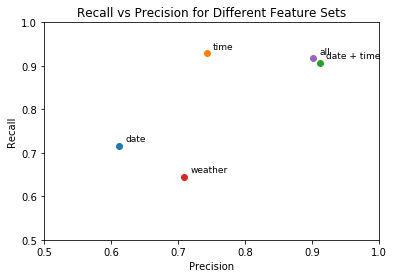

In [0]:
# Set up plot
plt.xlim(0.5,1)
plt.xlabel("Precision")
plt.ylim(0.5,1)
plt.ylabel("Recall")
plt.title("Recall vs Precision for Different Feature Sets")

# Plot data
names = list(feature_sets.keys())
for i in range(len(precisions)):
    x = precisions[i]
    y = recalls[i]
    plt.scatter(x, y)
    plt.text(x+.01, y+.01, names[i], fontsize=9)

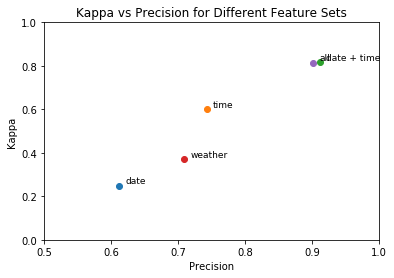

In [0]:
# Set up plot
plt.xlim(0.5,1)
plt.xlabel("Precision")
plt.ylim(0,1)
plt.ylabel("Kappa")
plt.title("Kappa vs Precision for Different Feature Sets")

# Plot data
names = list(feature_sets.keys())
for i in range(len(kappas)):
    x = precisions[i]
    y = kappas[i]
    plt.scatter(x, y)
    plt.text(x+.01, y+.01, names[i], fontsize=9)

## Statistical significance of differences with a train/test set

The following code check, for each pair of models that we have trained, whether or not the models are making significantly different predictions. Here, we are using the [Wilcoxon Signed-Rank Test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) to get an associated test statistic and p-value for each pair of models.

In [0]:
matches = {}

for feature_set in predictions.keys():
    boolean_matches = (predictions[feature_set] == actual)
    int_matches = [int(x) for x in boolean_matches]
    matches[feature_set] = int_matches

for set_a in matches.keys():
    for set_b in matches.keys():
        if set_a != set_b:
            matches_a = matches[set_a]
            matches_b = matches[set_b]
            t, p = stats.wilcoxon(matches_a, matches_b)
            print(f"{set_a} || {set_b}: t={t:.1f}, p={p:.3f}")
    print('------')


date || time: t=208502.0, p=0.000
date || date + time: t=44405.0, p=0.000
date || weather: t=170945.0, p=0.000
date || all: t=48530.0, p=0.000
------
time || date: t=208502.0, p=0.000
time || date + time: t=23362.5, p=0.000
time || weather: t=128527.0, p=0.000
time || all: t=21650.0, p=0.000
------
date + time || date: t=44405.0, p=0.000
date + time || time: t=23362.5, p=0.000
date + time || weather: t=41170.0, p=0.000
date + time || all: t=9554.5, p=0.886
------
weather || date: t=170945.0, p=0.000
weather || time: t=128527.0, p=0.000
weather || date + time: t=41170.0, p=0.000
weather || all: t=38720.0, p=0.000
------
all || date: t=48530.0, p=0.000
all || time: t=21650.0, p=0.000
all || date + time: t=9554.5, p=0.886
all || weather: t=38720.0, p=0.000
------


We can see that almost all the pairs of models are pretty different in this cases, indicating that splitting by different features results in models with significantly different predictions! The only two models that don't have significantly different predictions are the models using date/time and date/time/weather, indicating that weather only plays a small role in the model that uses all 3 feature subets!

# Logistic Regression 

Now that we are starting to get comfortable with decision trees and the basics of machine learnings, lets add a new model to our classification toolkit. Logistic regression is one of the most commonly used machine learning methods in use today. The intuitive idea behind logstic regression is simple -- take our test data and find the line (or plane) that best splits it into the two groups. This is in contrast with decision trees which use a series of if/then statements to split up the data. Logistic regression is very useful when the data has some sort of linear relationship and also comes with the benefit of being easy to interpret. [Here's some more on logistic regression.](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc)

![alt text](https://miro.medium.com/max/1280/1*bcWJyX3iAIr0MGNIxUnQxg.png)


## Implementation by hand

There are a few functions that we must implement in order to train a logistic regression model by hand. Lets consider each part individually, starting with the model itself.

The logistic regression model has two essential computational steps. The first is a linear transformation and the second is the logistic function. Intuitively, we can think of the first step as assigning diferent weights (we will call these weights $\beta$) to each of the data features and taking a weighted average of them all to get a single number to represent the data points. The logistic function then squashes this number between 0 and 1 for us, which turns out to be useful in training. The logistic function looks a bit like this:

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/480px-Logistic-curve.svg.png)

In equations, a logistic regression model can be expressed as the following:

$$ \hat{y} = \frac{1}{1 + e^{-X \beta^T}}$$

Lets also implement this in code:

In [0]:
def logistic_regression_model(beta, X): 
    return 1.0/(1 + np.exp(-np.dot(X, beta.T)))

Now that we can evaluate the model for a given input and $\beta$, we need to consider how to train the model. Many of the techniques used in practice boil down to variants of one core technique -- Gradient Descent. The inuitive idea behind gradient descent is quite simple. First we evaluate our model with some cost function. Then we take the gradients of each of the parameters ($\beta$s) of our model with respect to the cost function. Finally we move our parameters in the negative direction of the gradient to decrease our cost function. We then repeat this until we converge to a good model. [This resource provides some nice visuals to see what this looks like](https://hackernoon.com/dl03-gradient-descent-719aff91c7d6)

![alt text](https://hackernoon.com/hn-images/0*D7zG46WrdKx54pbU.gif)

For classification tasks, a good choice of gradient descent cost function is cross entropy loss which is defined as follows:

$$ cross \space entropy = \frac{1}{N}\sum_{y_i \in Y} y_ilog(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i)$$

where $y_i$ are the real labels and $\hat{y}_i$ are the corresponding predicted labels. Now lets write this out in code as well:

In [0]:
# Function to compute the cross entropy between a model's output and the true labels
def cross_entropy_cost(beta, X, y): 
    # evaluate the model for a given beta
    log_func_v = logistic_regression_model(beta, X) 
    y = np.squeeze(y) 
    
    # compute the cross entropy for each data point
    step1 = y * np.log(log_func_v) 
    step2 = (1 - y) * np.log(1 - log_func_v) 
    final = -step1 -step2 

    # return the average over all the data points
    return np.mean(final) 

# Function to compute the gradients of the cost for each parameter -- don't worry too much about the math
def partial_derivative(beta, X, y): 
    new_y = y.reshape(X.shape[0], -1) 
    first_calc = logistic_regression_model(beta, X) - new_y
    final_calc = np.dot(first_calc.T, X) / len(X)
    return final_calc 

# Finally lets put it all together to train with gradient descent
def gradient_descent(X, y, learning_rate=1, minimum_change=.0001): 

    # Initialize model betas to 0 before starting training
    beta = [0] * X.shape[1]
    beta = np.matrix(beta)

    # Compute our initial loss and initalize some variables
    cost = cross_entropy_cost(beta, X, y) 
    change_in_cost = 1
    num_iter = 1
    
    # If our loss is still changing enough from iteration to iteration
    while(change_in_cost > minimum_change): 
        old_cost = cost 

        # Update the betas of our model using its gradient and compute the new cost
        beta = beta - (learning_rate * partial_derivative(beta, X, y)) 
        cost = cross_entropy_cost(beta, X, y) 
        
        # Check the change in cost so we know if we should stop training
        change_in_cost = old_cost - cost 

        # Ocassionally print out some updates on the training
        if num_iter % 1000 == 0:
            print(f"Iteration {num_iter}: {change_in_cost:.5f} change in cost.")
        num_iter += 1
      
    # Return the number of iterations spent training and the final betas
    return np.array(beta).squeeze(), num_iter 

Before we run our model, let's also normalize our training data. When using gradient descent, we usually want to normalize our data before training. This helps with numerical stability (helps us avoid really small or really big numbers where the computer will have issues) and usually results in much quicker model convergence. An important point to note, however, is that it is very important to normalize your train and test data in the same way! For example, if you subtract the mean of you train data from all the train data points to normalize your train data to have mean 0, you should use should subtract that same value from the test data points (instead of using the test data mean).

In [0]:
# Generally, normalizing our data helps our model converge faster
def normalize(column): 
    mins = min(column)
    maxs = max(column)
    column_range = maxs - mins 
    normalized = column / column_range
    return normalized 

In [0]:
# Get our dataset
X = bikeshare.loc[:, weather_features]
X = pd.get_dummies(X)
X = X.apply(normalize)
y = bikeshare["high_traffic"]

# Move our data to numpy
X = np.matrix(X)
y = np.matrix(y)

Now that we have implemented everything we need to run a logstic regression model, lets run it on some data and see how it does!

In [0]:
# Train our model, and save our beta values
beta, num_iter = gradient_descent(X, y) 

print("Estimated regression coefficients:", beta) 
print("No. of iterations:", num_iter) 

# Use our model to make predictions for our data
output_probabilities = logistic_regression_model(beta, X)
output_probabilities = output_probabilities.tolist()[0]
threshold = 0.5
preds = [x > threshold for x in output_probabilities]

# Print out some metrics based on our predictions
y = np.array(y).squeeze()
accuracy = 100*accuracy_score(y, preds)
kappa = cohen_kappa_score(y, preds)
precision = precision_score(y, preds)
recall = recall_score(y, preds)
print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")

Iteration 1000: 0.00084 change in cost.
Iteration 2000: 0.00019 change in cost.
Iteration 3000: 0.00015 change in cost.
Iteration 4000: 0.00012 change in cost.
Iteration 5000: 0.00010 change in cost.
Estimated regression coefficients: [ 0.18651935  1.99991752  2.77171851 -4.1097967   0.07498157]
No. of iterations: 5053
Accuracy: 70.8 Kappa: 0.415 Precision: 0.717 Recall: 0.685


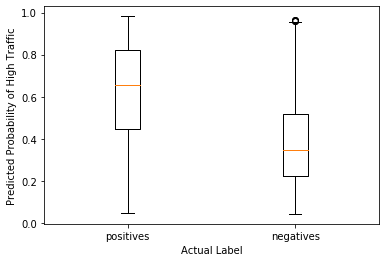

In [0]:
# Prepare data to be plotted
prob_series = pd.Series(output_probabilities)
actual = pd.Series(bikeshare['high_traffic'])
positives = prob_series.loc[actual == True]
negatives = prob_series.loc[actual == False]

# Set up plot
ax.set_xticklabels(["High Traffic", "Low Traffic"])
plt.ylabel("Predicted Probability of High Traffic")
plt.xlabel("Actual Label")

# Plot data
plt.boxplot([positives, negatives], labels = ['positives', 'negatives'])
ax = plt.gca()
plt.show()

Check out how the model mostly predicts higher values (above .5) when the actual label is True and mostly predicts lower values (below .5) when the actual label is False.

## Logistic Regression with scikit-learn

In [0]:
# Prepare data
X = bikeshare.loc[:, weather_features]
X = pd.get_dummies(X)
y = bikeshare["high_traffic"]

# Train model
classifier = LogisticRegression(penalty="none", solver="lbfgs", max_iter=10000, random_state=123)
model = classifier.fit(X, y)

# Get Predictions
preds = model.predict(X)

# Compute and print metrics
accuracy = 100*accuracy_score(y, preds)
kappa = cohen_kappa_score(y, preds)
precision = precision_score(y, preds)
recall = recall_score(y, preds)
print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")

Accuracy: 70.8 Kappa: 0.415 Precision: 0.720 Recall: 0.678


## Comparisons Between Classification Algorithms

Now that we have two completely different types of models, lets compare them and see which model is best for modeling this dataset!

In [0]:
# Define a function that takes in the predictions of a classifier, the true labels,
# and a set of metrics and displays the model's performance on the metrics
def common_evaluations(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Metrics
    conf_matrix = confusion_matrix(y_actual, y_pred)
    model_results = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_results[metric_name] = result

    # Display Metrics
    print(f"Results for {model_name}:")
    ConfusionMatrixDisplay(conf_matrix, ["low traffic", "high traffic"]).plot(values_format='.4g')
    plt.show()
    print(model_results)
    print("------------------------")

    return model_results
    

Results for Decision Tree:


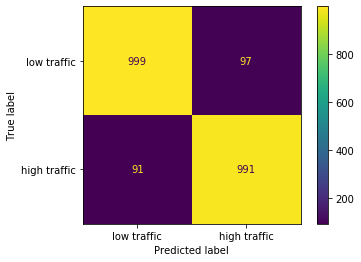

{'Accuracy': 91.3682277318641, 'Kappa': 0.827363535635805, 'Precision': 0.9108455882352942, 'Recall': 0.9158964879852126}
------------------------
Results for Logistic Regression:


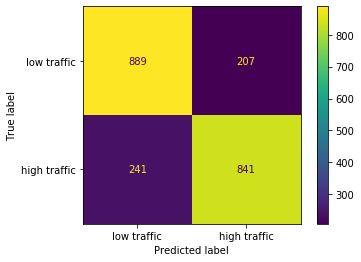

{'Accuracy': 79.43067033976125, 'Kappa': 0.5885138246710199, 'Precision': 0.8024809160305344, 'Recall': 0.777264325323475}
------------------------
Best classifier is: Decision Tree 
With: 91.4% accuracy.


In [0]:
# Set a list of classifiers we want to compare
classifiers = {
    "Decision Tree"      : DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", max_iter=10000, random_state=123),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score,
    "Precision": precision_score,
    "Recall"   : recall_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Choose a subset of features for our dataset
date_features = ["day", "month", "year", "weekday", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Create our train/test split using this subset of features
X = bikeshare.loc[:, feature_set]
y = bikeshare["high_traffic"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=12345)

# Create variables to keep track of our best model and the metrics for each model
best_model_metric = 0
best_model_name = None

all_model_metrics = {metric: [] for metric in metrics}

# For each model in our set of classifiers
for classifier_name, classifier in classifiers.items():

    # Train the classifier and get its predictions on the test set
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate our metrics on the data 
    model_results = common_evaluations(y_pred, y_test, metrics, classifier_name)
    
    # Update our best model if this model is better than our previous best
    comparison_metric = model_results[metric_to_optimize]
    if comparison_metric > best_model_metric:
        best_model_metric = comparison_metric
        best_model_name = classifier_name

    # Store the metrics for this model
    for metric in model_results:
        all_model_metrics[metric].append(model_results[metric]) 
    
print(f"Best classifier is: {best_model_name} \nWith: {best_model_metric:.1f}% accuracy.")   

The code above is an example of good data science code. We are easily able to change and scale up our experiment with only minor modification. For example, we could easily change our set of classifiers, set of metrics, evaluation metric, and set of features to run new comparions. While it takes some practice to be able to write code like this, you will quickly find that this will reduce the time that it takes to set up a new experiment by orders of magnitudes and that it results in code that is much more concise and easy to read!

Before we conclude this section, lets make a plot to visualize the difference in precision and recall between our two models.

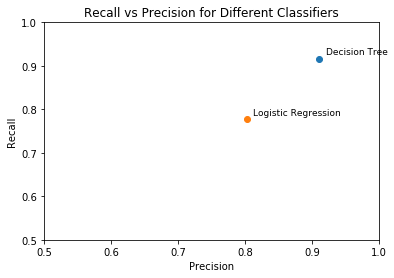

In [0]:
# Set up plot
plt.xlim(0.5,1)
plt.xlabel("Precision")
plt.ylim(0.5,1)
plt.ylabel("Recall")
plt.title("Recall vs Precision for Different Classifiers")

# Plot data
names = list(classifiers.keys())
for i in range(len(classifiers)):
    x = all_model_metrics['Precision'][i]
    y = all_model_metrics['Recall'][i]
    plt.scatter(x, y)
    plt.text(x+.01, y+.01, names[i], fontsize=9)

For this dataset, we can see that decision trees blow logistic regression out of the water since we get much better precision and recall with them. While, at first, it may seem like the only to figure this out would be to train and evaluate both of the models, we actually could have figured this out just by considering the properties of the two models and our data! Let's think about how we could have done that.

From our experiments with trees, we know that date and time are strong predictors of bikeshare traffic level. The question is, why is logistic regression not able to use this data effectively? The answer is actually pretty simple. The numerical ordering for date and time don't make sense. For example, December and January are very close together. In contrast, when we look at our data, January and December are actually really far apart because they are Month 1 and Month 12 respectively! Furthermore, the same thing thing happens when we look at the time of day or day of the week!

When we use decision trees, we can draw multiple lines between months to use in our classification, but with logistic regression we can only draw one. This means that for logistic regression, there is no way to make up for this discrepancy between the true cyclical structure of the months and their ordered representation in our dataset. The problem is not the model, but the format of the data (oops!). This is an awesome example of how data format influences model choice and model choice influences data format!

# Tomorrow
Tomorrow, we'll dive into much more detail on experimental setup and the type of tuning and evaluation that you can do once you have multiple classifiers, feature sets, and other aspects of classification to tune.